# Homework 5: High Dimensional Significance

## Problem 1: Movie Lens

Download the Movie Lens 100K dataset from 

https://grouplens.org/datasets/movielens/100k/

Naively complete the data in the same manner discussed in HW4 Problem 1, but do not perform the full matrix completion yet

### Part A: Use the graphical LASSO (*sklearn.covariance.GraphicalLasso*) to fit a precision matrix to the data given this estimate for the covariance matrix. Use 10-fold cross validation to choose the appropriate $\lambda$ value. Compare this with HW4 Problem 1 Part A.

### Part B: Use the precision matrix from Part A to fill in the missing data for each row. Follow the instructions here to install UMAP:

https://umap-learn.readthedocs.io/en/latest/

### Use UMAP to create two 2D embeddings -- one for the users and one for the movies. Discuss your observations.


### Part A

In [19]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.covariance import GraphicalLassoCV
import matplotlib.pyplot as plt
import numpy.random as rd
import random
import plotly.express as px
import numpy.linalg as la
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix
import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
%load_ext rpy2.ipython

utils = importr('utils')
select_infer = importr('selectiveInference')
base = importr('base')
cv_glmnet = importr('glmnet')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
df=pd.read_csv('u.data',sep='\t', names=['user','item','rating','timestamp'])
df=df.drop(columns=['timestamp'])

In [3]:

df_total=csr_matrix((np.array(df['rating']),(np.array(df['user'])-1,np.array(df['item'])-1)),shape=(943,1682)).toarray()

In [4]:
df_raw=np.array(df_total)

In [5]:
for i in range(1682):
    tempCol = df_total[:,i]
    reCol = tempCol[tempCol!=0]
    tempCol[tempCol==0]=np.median(reCol)
    df_total[:,i]=tempCol

In [6]:
df_copy = np.array(df_total).astype(np.float)
means=df_copy.mean(axis=0)
stds=df_copy.std(axis=0)
scaler = preprocessing.StandardScaler()
df_copy = scaler.fit_transform(df_copy)

In [8]:
df_copy = df_copy + 0.01 * rd.normal(size=df_copy.shape)

In [11]:
model=GraphicalLassoCV(cv=10, n_jobs=-1, mode='cd')
model.fit(df_copy)

GraphicalLassoCV(cv=10, n_jobs=-1)

In [13]:
model_raw = GraphicalLassoCV(cv=5, n_jobs=-1, mode='cd')
model_raw.fit(df_copy)

GraphicalLassoCV(cv=5, n_jobs=-1)

In [14]:
model.alpha_

0.5484614032570556

In [15]:
model_raw.alpha_

0.5760754978414869

### Part B

In [17]:
cov = model.covariance_
K = model.precision_

In [18]:
df_new = np.array(df_raw)

array([False,  True,  True, ...,  True,  True,  True])

In [23]:
for i in range(943):
    cur_ind = df_raw[i,:] != 0
    pre_ind = df_raw[i,:] == 0
    temp = means[pre_ind] - cov[np.ix_(pre_ind,pre_ind)]@K[np.ix_(pre_ind,cur_ind)]\
    @(df_raw[np.ix_([i],cur_ind)].flatten())*(stds[pre_ind])
    df_new[i,pre_ind]=np.round(temp)

In [39]:

reducer = umap.UMAP()

In [43]:
movie_data = np.array(df_new)
scaled_movie_data = preprocessing.StandardScaler().fit_transform(movie_data)


In [47]:
embedding_1 = reducer.fit_transform(scaled_movie_data)
embedding_2 = reducer.fit_transform(scaled_movie_data.T)

(943, 1682)

Text(0.5, 1.0, 'UMAP projection of the Users')

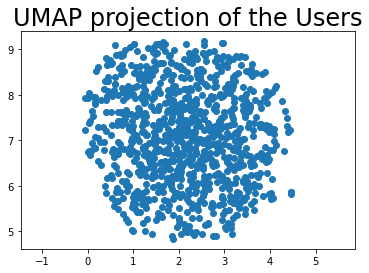

In [55]:
plt.scatter(
    embedding_1[:, 0],
    embedding_1[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Users', fontsize=24)

Text(0.5, 1.0, 'UMAP projection of the Movies')

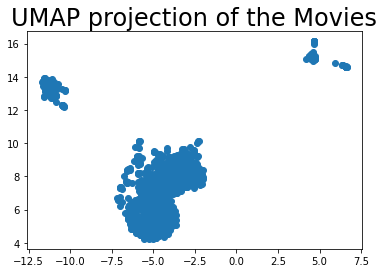

In [56]:
plt.scatter(
    embedding_2[:, 0],
    embedding_2[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Movies', fontsize=24)

### Comment:
As we can see, the umap projection of the users is composed of one part while the umap projections of movies is composed of more than one parts.

## Problem 2: Riboflavin Data Significance

### Part A: Use the Riboflavin dataset from Homework 1, and apply the **fsInf** and **fixedLassoInf** function from the **selectiveInference** R package to perform inference for forward stepwise regression and LASSO. For the **fixedLassoInf** function, use $\lambda.\min$ obtained from the **cv.glmnet** function from the **glmnet** R package. Compare and contrast the results from these two methods for inference. 

### Part B: Use UMAP to visualize both the row set and the column set from the Riboflavin design matrix -- that is, visualize the patients and also the gene expressions across the patients. Do this for the raw data, and also for the data after standardization of the variables. Compare these embeddings with embeddings from $t$-SNE.

### Part A

In [319]:
df_rx=pd.read_csv('riboflavin/riboflavinx.csv')
df_ry=pd.read_csv('riboflavin/riboflaviny.csv')
rx=np.array(df_rx.iloc[:,1:4089])
ry=np.array(df_ry.iloc[:,1])
ry = np.expand_dims(ry, axis=0)
ry = ry.flatten()
rx_raw = np.array(rx)
ry_raw = np.array(ry)

In [320]:
rx = preprocessing.StandardScaler().fit_transform(rx)

In [323]:
%R -i rx,ry

In [324]:
robjects.r('model = fs(rx,ry);\
print(fsInf(model));\
pred = as.vector(predict(model,rx,s=70));\
print(sum((pred-ry)^2));\
')


Call:
fsInf(obj = model)

Standard deviation of noise (specified or estimated) sigma = 0.920

Sequential testing results with alpha = 0.100
 Step  Var   Coef Z-score P-value LowConfPt UpConfPt LowTailArea UpTailArea
    1 1278  0.593   5.433   0.080    -0.113    0.750       0.050      0.049
    2 4003 -0.431  -3.817   0.110    -1.373    0.199       0.050      0.050
    3 2564 -0.327  -2.755   0.319    -0.792    0.658       0.050      0.000
    4   73 -0.315  -2.676   0.332    -1.019    0.738       0.050      0.050
    5 2034  0.234   1.833   0.246    -0.573    1.548       0.050      0.050
    6 1131  0.124   1.111   0.768    -2.137    0.356       0.050      0.049
    7 1762 -0.120  -1.008   1.000    11.884      Inf       0.007      0.000
    8 2186  0.143   0.927   0.004    15.457      Inf       0.011      0.000
    9 3495  0.093   0.699   0.004    13.309      Inf       0.027      0.000
   10 3499 -0.138  -0.775   0.006      -Inf  -17.797       0.000      0.023
   11 1595  0.134   0.8

0.000000


In [5]:
#rx_R = robjects.r.matrix(robjects.FloatVector(rx.flatten()), nrow=71, ncol = 200)
#ry_R = robjects.FloatVector(ry)
#final_result = select_infer.fsInf(select_infer.fs(rx_R,ry_R))

In [194]:
robjects.r('x=matrix(rx,71,200);\
n=nrow(x);\
y=matrix(ry);\
model = cv.glmnet(x,y,nlambda=1000);\
sigmahat = estimateSigma(x,y,stand=F)$sigmahat;\
lambda = n*model$lambda.min;\
bhat = coef(model, s=lambda/n, exact=TRUE)[-1];\
print(fixedLassoInf(x,y,beta = bhat,lambda = lambda,sigma=sigmahat));\
pred = as.vector(predict(model,rx,s=70));\
print(sum((pred-ry)^2));\
')


Call:
fixedLassoInf(x = x, y = y, beta = bhat, lambda = lambda, sigma = sigmahat)

Standard deviation of noise (specified or estimated) sigma = 0.359

Testing results at lambda = 2.468, with alpha = 0.100

 Var   Coef Z-score P-value LowConfPt UpConfPt LowTailArea UpTailArea
  10  0.066   0.661   0.346    -3.338    6.734        0.05       0.05
  16 -0.124  -1.169   0.434    -2.618    2.084        0.05       0.05
  20 -0.023  -0.241   0.303      -Inf    4.618        0.00       0.05
  29 -0.036  -0.284   0.874    -2.078      Inf        0.05       0.00
  44 -0.233  -2.574   0.212    -1.441    0.440        0.05       0.05
  46  0.154   1.603   0.727    -3.416    0.928        0.05       0.05
  55 -0.174  -1.870   0.399    -4.403    2.960        0.05       0.05
  57 -0.194  -1.935   0.453    -2.959    2.623        0.05       0.05
  64  0.093   0.939   0.046     0.021    6.202        0.05       0.05
  67  0.158   1.143   0.440    -9.241   11.875        0.05       0.05
  68 -0.022  -0.230   0

59.302830


### Comment
In the method of fsInf we get 70 predictors, while in the method of fixedLassoInf we get 33 predictors. But in lasso we have larger errors.

### Part B

In [131]:
rd.seed(3)

In [238]:
rx.shape

(71, 200)

In [325]:
embedding_p_r = umap.UMAP().fit_transform(rx_raw)
embedding_g_r = umap.UMAP().fit_transform(rx_raw.T)
embedding_p_s = umap.UMAP().fit_transform(rx)
embedding_g_s = umap.UMAP().fit_transform(StandardScaler().fit_transform(rx_raw.T))

Text(0.5, 1.0, 'UMAP projection of the Patients (Raw)')

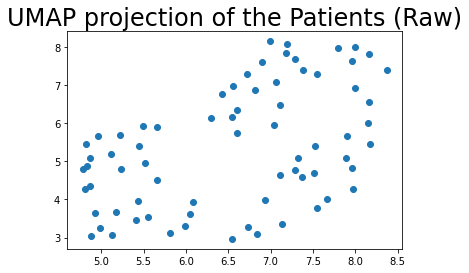

In [326]:
plt.scatter(
    embedding_p_r[:, 0],
    embedding_p_r[:, 1])
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Patients (Raw)', fontsize=24)

Text(0.5, 1.0, 'UMAP projection of the Genes (Raw)')

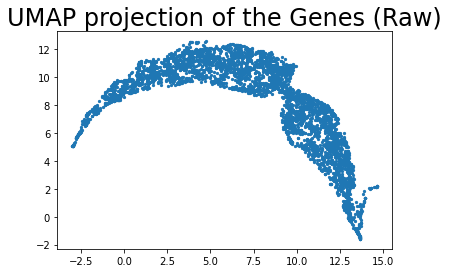

In [331]:
plt.scatter(
    embedding_g_r[:, 0],
    embedding_g_r[:, 1],s=5)
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Genes (Raw)', fontsize=24)

Text(0.5, 1.0, 'UMAP projection of the Patients (Standardized)')

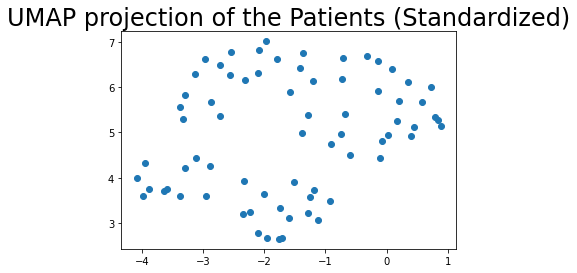

In [328]:
plt.scatter(
    embedding_p_s[:, 0],
    embedding_p_s[:, 1])
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Patients (Standardized)', fontsize=24)

Text(0.5, 1.0, 'UMAP projection of the Genes (Standardized)')

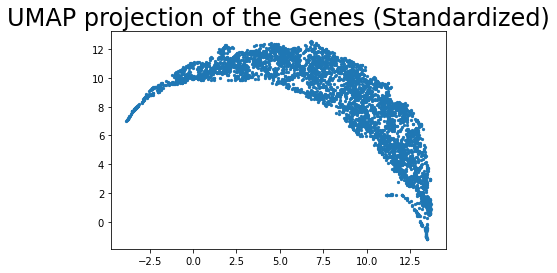

In [332]:
plt.scatter(
    embedding_g_s[:, 0],
    embedding_g_s[:, 1],s=5)
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Genes (Standardized)', fontsize=24)

In [330]:
embedding_p_r_tsne = TSNE().fit_transform(rx_raw)
embedding_g_r_tsne = TSNE().fit_transform(rx_raw.T)
embedding_p_s_tsne = TSNE().fit_transform(rx)
embedding_g_s_tsne = TSNE().fit_transform(StandardScaler().fit_transform(rx_raw.T))

Text(0.5, 1.0, 'TSNE projection of the Patients (Raw)')

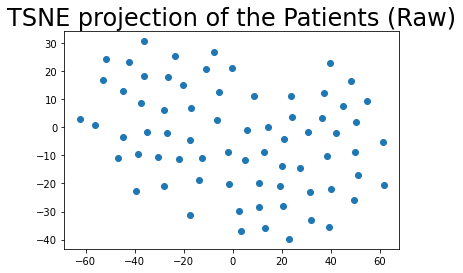

In [333]:
plt.scatter(
    embedding_p_r_tsne[:, 0],
    embedding_p_r_tsne[:, 1])
#plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection of the Patients (Raw)', fontsize=24)

Text(0.5, 1.0, 'TSNE projection of the Genes (Raw)')

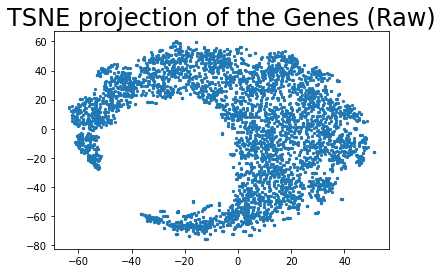

In [339]:
plt.scatter(
    embedding_g_r_tsne[:, 0],
    embedding_g_r_tsne[:, 1],s=5)
#plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection of the Genes (Raw)', fontsize=24)

Text(0.5, 1.0, 'TSNE projection of the Patients (Standardized)')

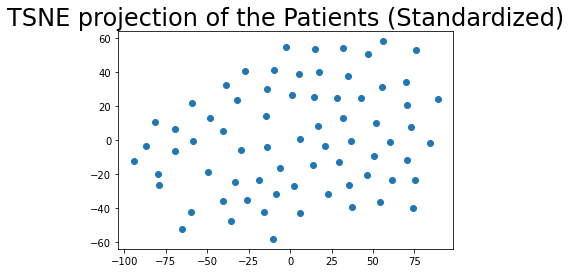

In [338]:
plt.scatter(
    embedding_p_s_tsne[:, 0],
    embedding_p_s_tsne[:, 1])
#plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection of the Patients (Standardized)', fontsize=24)

Text(0.5, 1.0, 'TSNE projection of the Genes (Standardized)')

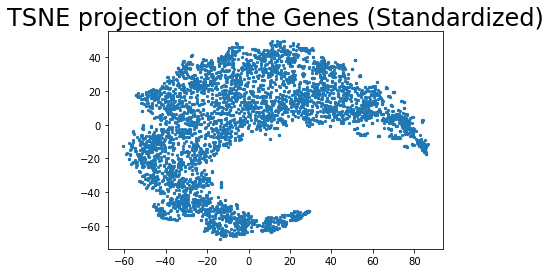

In [340]:
plt.scatter(
    embedding_g_s_tsne[:, 0],
    embedding_g_s_tsne[:, 1],s=5)
#plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection of the Genes (Standardized)', fontsize=24)

### Comment
In this case, the topologies of UMAP and TSNE projection are similar. Standardization change the distance of points under projection in some directions. From both projections of the genes, we can see strong correlations between the two extracted features, which indicates some relationship among the original features.

## Problem 3: S&P 500 log-returns data

### Part A: Use the log-returns data from Homework 1 and 2, and apply the **fsInf** and **fixedLassoInf** function from the **selectiveInference** R package to perform inference for forward stepwise regression and LASSO. For the **fixedLassoInf** function, use $\lambda.\min$ obtained from the **cv.glmnet** function from the **glmnet** R package. Compare and contrast the results from these two methods for inference. 

### Part B: Use UMAP to visualize the relationships between the log-returns of the symbols over the year. Be sure to first standardize each symbol, and explain what you observe.-- that is, visualize the patients and also the gene expressions across the patients. Do this for the raw data, and also for the data after standardization of the variables. Compare this embeddings with embedding from $t$-SNE.

### Part C: For each of the symbols from the S&P 500 log-returns data, use the **trendfilter** function from the **genlasso** R package with **ord=3** to fit a regularized function to the daily log-returns data for the year. Describe what type of model selection this function is doing, and explain what you observe for your results.

### Part A

In [3]:
df = pd.read_csv("./finance/data.csv")

In [4]:
nanix = [7, 52, 56, 65, 70, 71, 72, 75, 94, 99, 122, 125, 138, 170, 174, 177, 193, 203, 226, 260, 282, 308, 309, 326, 335, 352, 365, 389, 404]

data = np.zeros((433-len(nanix),251))
k = 0

for i in range(433):
    q = np.diff(np.log(np.array(df['Open.' + str(i+1)][2:].astype(float))))
    if np.sum(np.isnan(q)) == 0:
        data[k,:]=np.diff(np.log(np.array(df['Open.' + str(i+1)][2:].astype(float))))
        k=k+1
        


In [16]:
xsp = StandardScaler().fit_transform(data.T).T
X_sp = xsp[:,0:250].T
Y_sp = xsp[36,1:251]

(250,)

We use all the log-returns of the first day as predictors, and the log-return of the 37th symbol at the second day as the response. (In hw4, we detected relationships between the 37th symbol at the second day and other symbols at the first day.)

In [17]:
%R -i X_sp,Y_sp

In [21]:
robjects.r('model = fs(X_sp,Y_sp);\
print(fsInf(model));\
pred = as.vector(predict(model,X_sp,s=249));\
print(sum((pred-Y_sp)^2));\
')


Call:
fsInf(obj = model)

Standard deviation of noise (specified or estimated) sigma = 1.004

Sequential testing results with alpha = 0.100
 Step Var   Coef Z-score P-value LowConfPt UpConfPt LowTailArea UpTailArea
    1   3 -0.186  -2.936   0.248    -0.276    0.229       0.049      0.050
    2 320  0.170   2.617   0.646    -1.135    0.286       0.050      0.049
    3 185 -0.156  -2.239   0.875    -0.151    3.909       0.050      0.050
    4 181  0.166   2.460   0.142    -0.445    3.684       0.050      0.050
    5 196 -0.155  -2.400   0.426    -1.996    1.600       0.050      0.050
    6  61  0.132   1.923   0.595    -1.127    0.563       0.050      0.050
    7   9 -0.166  -2.126   0.688    -0.804    2.466       0.050      0.050
    8 383 -0.146  -2.153   0.157    -1.797    0.291       0.050      0.050
    9 387  0.147   1.939   0.872    -7.530    0.494       0.050      0.050
   10 148 -0.226  -2.629   0.069    -1.197    0.047       0.050      0.049
   11 201  0.142   1.868   0.792  

  216 107 -0.020  -0.070   0.173      -Inf      Inf       0.000      0.000
  217  22 -0.025  -0.069   0.456      -Inf      Inf       0.000      0.000
  218  42  0.021   0.059   0.881      -Inf      Inf       0.000      0.000
  219 316  0.015   0.054   0.617      -Inf      Inf       0.000      0.000
  220 241  0.015   0.054   0.523      -Inf      Inf       0.000      0.000
  221  33 -0.024  -0.052   0.480      -Inf      Inf       0.000      0.000
  222 327  0.014   0.046   0.857      -Inf      Inf       0.000      0.000
  223 172  0.011   0.043   0.760      -Inf      Inf       0.000      0.000
  224 226  0.017   0.037   0.900      -Inf      Inf       0.000      0.000
  225 404  0.013   0.042   0.102      -Inf      Inf       0.000      0.000
  226 217  0.012   0.039   0.073   -21.281      Inf       0.050      0.000
  227 358 -0.007  -0.024   0.703      -Inf      Inf       0.000      0.000
  228  91  0.006   0.020   0.555      -Inf      Inf       0.000      0.000
  229 243 -0.006  -0.018 

0.000000


In [23]:
robjects.r('x=matrix(X_sp,250,404);\
n=nrow(x);\
y=matrix(Y_sp);\
model = cv.glmnet(x,y);\
sigmahat = estimateSigma(x,y,stand=F)$sigmahat;\
lambda = n*model$lambda.min;\
bhat = coef(model, s=lambda/n, exact=TRUE)[-1];\
print(fixedLassoInf(x,y,beta = bhat,lambda = lambda,sigma=sigmahat));\
')


Call:
fixedLassoInf(x = x, y = y, beta = bhat, lambda = lambda, sigma = sigmahat)

Standard deviation of noise (specified or estimated) sigma = 1.006

Testing results at lambda = 44.478, with alpha = 0.100

 Var   Coef Z-score P-value LowConfPt UpConfPt LowTailArea UpTailArea
   3 -0.186  -2.931   0.646    -0.233    1.191        0.05       0.05

Note: coefficients shown are partial regression coefficients


<rpy2.rinterface_lib.sexp.NULLType object at 0x0000023F97044E08> [RTYPES.NILSXP]

### Comment
In lasso, we achieve a model with only 1 predictor, that's the only variable at the first day detected to have relatively strong relationship with the 37th variable at the second day.

### Part B

In [224]:
embedding_u = umap.UMAP().fit_transform(xsp)
embedding_t = TSNE().fit_transform(xsp)

Text(0.5, 1.0, 'UMAP projection of the Symbols (Standardized)')

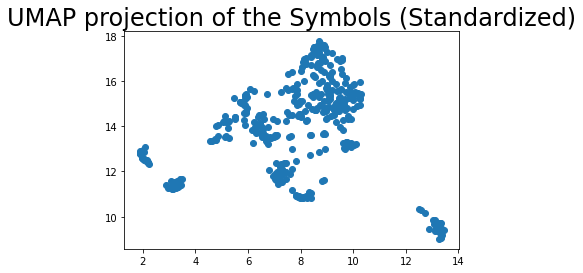

In [225]:
plt.scatter(
    embedding_u[:, 0],
    embedding_u[:, 1])
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Symbols (Standardized)', fontsize=24)

Text(0.5, 1.0, 'TSNE projection of the Symbols (Standardized)')

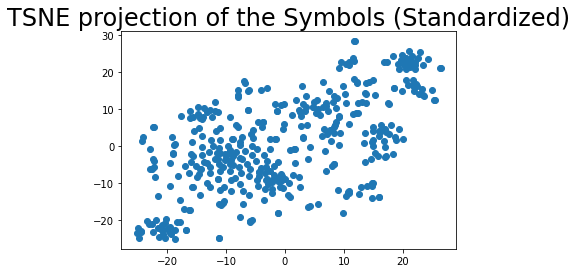

In [226]:
plt.scatter(
    embedding_t[:, 0],
    embedding_t[:, 1])
#plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection of the Symbols (Standardized)', fontsize=24)

### Comment
In this case, UMAP performs better than TSNE since in UMAP we can see clusters away from each other clearly.

### Part C

In [10]:
genlasso = importr('genlasso')
grdevices = importr('grDevices')

In [7]:
xsp.shape

(404, 251)

In [8]:
%R -i xsp

In [15]:
robjects.r('for(i in 1:404){ \
            cur_y = xsp[i,];\
            cur_a = trendfilter(cur_y,ord=3);\
            png(file=paste(\'pics/Symbol\',as.character(i),\'.png\',sep=''));\
            plot(cur_a,nlam=3,main=paste(\'Symbol\',str(i)));\
            dev.off();\
            }')

 int 1
 int 2
 int 3
 int 4
 int 5
 int 6
 int 7
 int 8
 int 9
 int 10
 int 11
 int 12
 int 13
 int 14
 int 15
 int 16
 int 17
 int 18
 int 19
 int 20
 int 21
 int 22
 int 23
 int 24
 int 25
 int 26
 int 27
 int 28
 int 29
 int 30
 int 31
 int 32
 int 33
 int 34
 int 35
 int 36
 int 37
 int 38
 int 39
 int 40
 int 41
 int 42
 int 43
 int 44
 int 45
 int 46
 int 47
 int 48
 int 49
 int 50
 int 51
 int 52
 int 53
 int 54
 int 55
 int 56
 int 57
 int 58
 int 59
 int 60
 int 61
 int 62
 int 63
 int 64
 int 65
 int 66
 int 67
 int 68
 int 69
 int 70
 int 71
 int 72
 int 73
 int 74
 int 75
 int 76
 int 77
 int 78
 int 79
 int 80
 int 81
 int 82
 int 83
 int 84
 int 85
 int 86
 int 87
 int 88
 int 89
 int 90
 int 91
 int 92
 int 93
 int 94
 int 95
 int 96
 int 97
 int 98
 int 99
 int 100
 int 101
 int 102
 int 103
 int 104
 int 105
 int 106
 int 107
 int 108
 int 109
 int 110
 int 111
 int 112
 int 113
 int 114
 int 115
 int 116
 int 117
 int 118
 int 119
 int 120
 int 121
 int 122
 int 123
 

<rpy2.rinterface_lib.sexp.NULLType object at 0x0000023F97044E08> [RTYPES.NILSXP]

Save all the figures to the folder of 'pics'.

### Comment
Trendfiltering solves the following optimizing problem given a chain of data $y$:
$$\hat{\beta}=\underset{\beta\in R^n}{\operatorname{argmin}}\frac{1}{2}\Vert y-\beta\Vert^2_2+\frac{n^k}{k!}\lambda\Vert D^{(k+1)}\beta\Vert_1 $$
where $\lambda\geq 0$ and $D^{(k+1)}$ is the discrete difference operator.  
The solution $\hat{\beta}$ gives an 'curve-like' approximation of the original data chain since the discrete difference operator is parallel to the derivatives in the continuous sense.  

In this case, the log returns seem to be randomly distributed but not correlated in the time axis. Thus only a small number of trendfiltering approximations seem to be close to the original data chain. Actually in hw4 we saw that there are relationships between different symbols in the continuous 2 days. So we cannot achieve a good result using only one variable in the time axis.

## Problem 4: Significance for LASSO logistic regression and the Prostate Dataset

### Part A: Use the Prostate dataset from HW3, and apply the **fixedLassoInf** function from the **selectiveInference** R package using the *family="binomial"* option to perform inference for $\ell_1$-regularized logistic regression. For the **fixedLassoInf** function, use $\lambda.\min$ obtained from the **cv.glmnet** (using the *family = "binomial"* option) function from the **glmnet** R package. Discuss your results.

### Part B: Use UMAP to visualize both the row set and the column set from the Prostate dataset -- that is, visualize the patients and also the gene expressions across the patients. Do this for the raw data, and also for the data after standardization of the variables. Compare these embeddings with embeddings from $t$-SNE.

### Part A

In [341]:
pX = pd.read_csv('prostate/prostate.csv')
pY = pX.iloc[:,-1]
pX = pX.iloc[:,1:6034]
pX_raw = np.array(pX)

In [342]:
pX = preprocessing.StandardScaler().fit_transform(pX)

In [234]:
%R -i pX,pY

In [232]:
pX.shape

(102, 6033)

In [235]:
robjects.r('x=matrix(pX,102,6033);\
n=nrow(x);\
y=matrix(pY);\
model = cv.glmnet(x,y,nlambda=1000,family=\'binomial\');\
sigmahat = estimateSigma(x,y,stand=F)$sigmahat;\
lambda = n*model$lambda.min;\
bhat = coef(model, s=lambda/n, exact=TRUE)[-1];\
print(fixedLassoInf(x,y,beta = bhat,lambda = lambda,sigma=sigmahat));\
pred = as.vector(predict(model,pX,s=70));\
print(sum((pred-pY)^2));\
')


Call:
fixedLassoInf(x = x, y = y, beta = bhat, lambda = lambda, sigma = sigmahat)

Standard deviation of noise (specified or estimated) sigma = 0.171

Testing results at lambda = 1.866, with alpha = 0.100

  Var   Coef Z-score P-value LowConfPt UpConfPt LowTailArea UpTailArea
  194  0.023   1.000       1      -Inf   -2.269           0          0
 1014 -0.040  -1.540       1     2.627      Inf           0          0
 1037  0.039   1.765       1      -Inf   -2.188           0        NaN
 1291  0.000   0.014       1      -Inf   -2.446           0          0
 1455  0.020   0.813       1      -Inf   -2.469           0        NaN
 1527 -0.031  -1.285       1     2.450      Inf           0          0
 1735  0.023   1.028       1      -Inf   -2.252           0        NaN
 1788  0.010   0.427       1      -Inf   -2.424           0        NaN
 1903 -0.018  -0.612       1     2.901      Inf         NaN          0
 1949 -0.016  -0.559       1     2.900      Inf         NaN          0
 2003 -0.043

48.077949


### Comment
We achieve a partial regression model as well as p-values and confidence interval of each variable. Plus, the error is acceptable.

### Part B

In [343]:
emb_p_r = umap.UMAP().fit_transform(pX_raw)
emb_g_r = umap.UMAP().fit_transform(pX_raw.T)
emb_p_s = umap.UMAP().fit_transform(pX)
emb_g_s = umap.UMAP().fit_transform(StandardScaler().fit_transform(pX_raw.T))

Text(0.5, 1.0, 'UMAP projection of the Patients (Raw)')

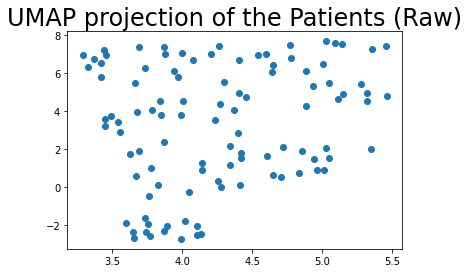

In [344]:
plt.scatter(
    emb_p_r[:, 0],
    emb_p_r[:, 1])
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Patients (Raw)', fontsize=24)

Text(0.5, 1.0, 'UMAP projection of the Genes (Raw)')

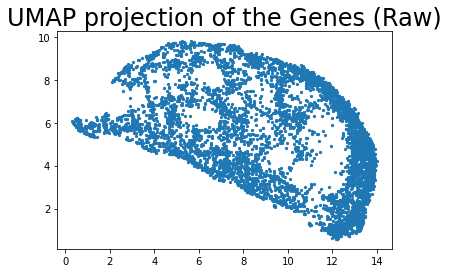

In [345]:
plt.scatter(
    emb_g_r[:, 0],
    emb_g_r[:, 1],s=5)
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Genes (Raw)', fontsize=24)

Text(0.5, 1.0, 'UMAP projection of the Patients (Standardized)')

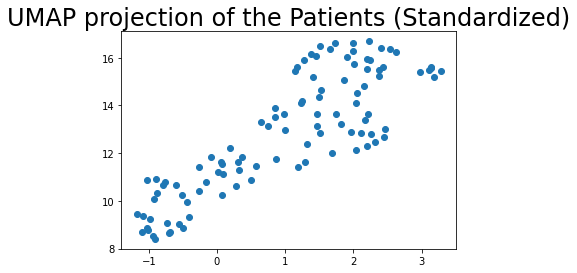

In [346]:
plt.scatter(
    emb_p_s[:, 0],
    emb_p_s[:, 1])
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Patients (Standardized)', fontsize=24)

Text(0.5, 1.0, 'UMAP projection of the Genes (Standardized)')

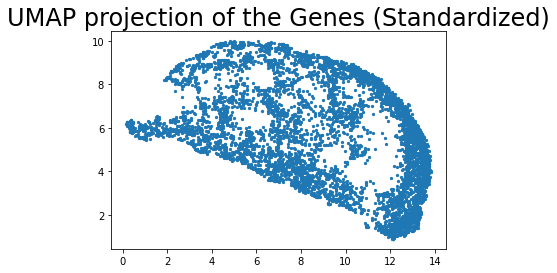

In [347]:
plt.scatter(
    emb_g_s[:, 0],
    emb_g_s[:, 1],s=5)
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Genes (Standardized)', fontsize=24)

In [348]:
emb_p_r_tsne = TSNE().fit_transform(pX_raw)
emb_g_r_tsne = TSNE().fit_transform(pX_raw.T)
emb_p_s_tsne = TSNE().fit_transform(pX)
emb_g_s_tsne = TSNE().fit_transform(StandardScaler().fit_transform(pX_raw.T))

Text(0.5, 1.0, 'TSNE projection of the Patients (Raw)')

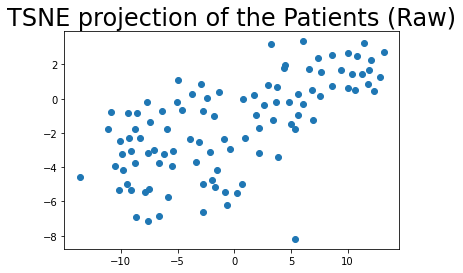

In [349]:
plt.scatter(
    emb_p_r_tsne[:, 0],
    emb_p_r_tsne[:, 1])
#plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection of the Patients (Raw)', fontsize=24)

Text(0.5, 1.0, 'TSNE projection of the Genes (Raw)')

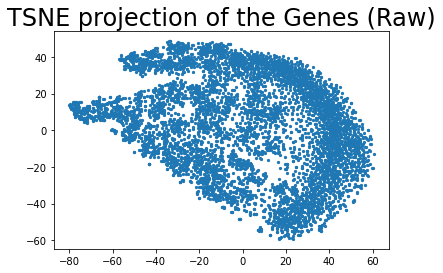

In [350]:
plt.scatter(
    emb_g_r_tsne[:, 0],
    emb_g_r_tsne[:, 1],s=5)
#plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection of the Genes (Raw)', fontsize=24)

Text(0.5, 1.0, 'TSNE projection of the Patients (Standardized)')

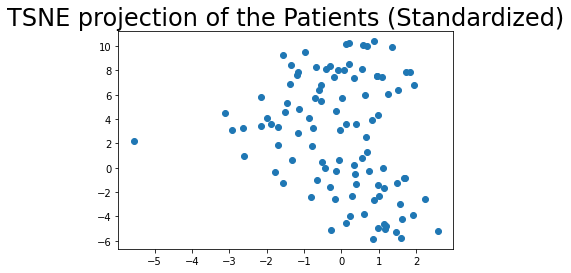

In [351]:
plt.scatter(
    emb_p_s_tsne[:, 0],
    emb_p_s_tsne[:, 1])
#plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection of the Patients (Standardized)', fontsize=24)

Text(0.5, 1.0, 'TSNE projection of the Genes (Standardized)')

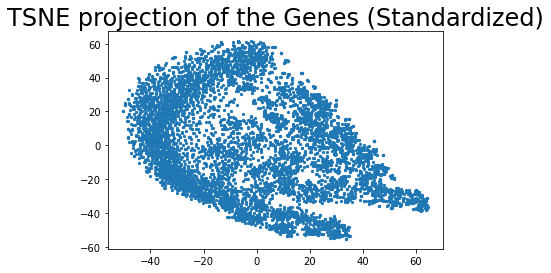

In [352]:
plt.scatter(
    emb_g_s_tsne[:, 0],
    emb_g_s_tsne[:, 1],s=5)
#plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection of the Genes (Standardized)', fontsize=24)

### Comment
There are correlation between extracted features of genes among patients, which could be found both from UMAP and TSNE. That indicates some relationship among the original genes.  

And for the projection of genes, we can see the topologies of UMAP projection and TSNE projection are similar. From UMAP projection, we can find a linear inequality constraint.

## Problem 5: Choose your own adventure

### Perform model selection and inference for a dataset of your choice, and also provide visualizations using UMAP. Provide an analysis of your results.

In [386]:
df1=pd.read_csv('data.csv')
df2=pd.read_csv('labels.csv')
df1=np.array(df1.iloc[:,1:20532])
df2=np.array(df2.iloc[:,1])
df1_raw = np.array(df1)
selected = random.sample([i for i in range(20531)],2000)
df1=df1[:,selected]

'data.csv' collects the gene expressions. 'labels.csv' represents the kinds of cancer.  
To carry out a logistic regression, we only consider whether the label is 'LUAD' or not, making it a binary-classification problem. (For the purpose of simplification, we can randomly choose 2000 features.)

In [387]:
labels=np.zeros(801)
labels[df2=='LUAD']=1

In [388]:
df1 = preprocessing.StandardScaler().fit_transform(df1)
df1 = np.unique(df1, axis=1)

In [389]:
df1.shape

(801, 1973)

In [390]:
%R -i df1,labels

In [392]:
robjects.r('x=matrix(df1,801,dim(df1)[2]);\
n=nrow(x);\
y=matrix(labels);\
model = cv.glmnet(x,y,nlambda=1000,family=\'binomial\');\
sigmahat = estimateSigma(x,y,stand=F)$sigmahat;\
lambda = n*model$lambda.min;\
bhat = coef(model, s=lambda/n, exact=TRUE)[-1];\
print(fixedLassoInf(x,y,beta = bhat,lambda = lambda,sigma=sigmahat));\
')


Call:
fixedLassoInf(x = x, y = y, beta = bhat, lambda = lambda, sigma = sigmahat)

Standard deviation of noise (specified or estimated) sigma = 0.068

Testing results at lambda = 2.725, with alpha = 0.100

  Var   Coef Z-score P-value LowConfPt UpConfPt LowTailArea UpTailArea
   86 -0.031 -10.575       1     0.297      Inf           0          0
  303  0.017   5.339       1      -Inf   -0.311           0        NaN
  357  0.012   3.288       1      -Inf   -0.373           0          0
  450  0.007   1.720       1      -Inf   -0.392           0        NaN
  469  0.020   5.621       1      -Inf   -0.359           0        NaN
  471  0.009   3.501       1      -Inf   -0.260           0          0
  475  0.036  12.366     NaN      -Inf   -0.287           0        NaN
  509  0.132  23.601       1      -Inf   -0.557           0        NaN
  586  0.010   3.787       1      -Inf   -0.276           0          0
  598  0.033   9.773       1      -Inf   -0.337           0          0
  634  0.022

<rpy2.rinterface_lib.sexp.NULLType object at 0x00000215D627DA88> [RTYPES.NILSXP]

### Coment
We achieve a partial classification model within the selected 2000 features.

In [394]:
emb = umap.UMAP().fit_transform(StandardScaler().fit_transform(df1_raw))

Text(0.5, 1.0, 'UMAP projection of the Patients (Standardized)')

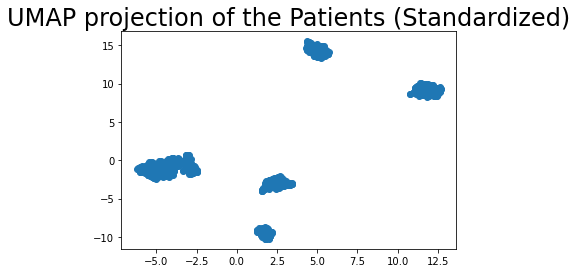

In [395]:
plt.scatter(
    emb[:, 0],
    emb[:, 1])
#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Patients (Standardized)', fontsize=24)

### Comment

We can clearly classify the patients into several groups.